## Deep Learning Based Traffic Sign Recognition Classifier

**Code will only work with Python 3** 

### Load The Data

In [47]:
!mkdir traffic-sign-data

In [1]:
import urllib.request

link = "https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip"
urllib.request.urlretrieve(link, "traffic-sign-data.zip")

import zipfile
zip_ref = zipfile.ZipFile('traffic-sign-data.zip', 'r')
zip_ref.extractall('traffic-sign-data')
zip_ref.close()

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-sign-data/train.p'
testing_file = 'traffic-sign-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

 Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [5]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 7
import seaborn as sns
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Number of training examples
n_train = X_train.shape[0]

#Number of testing examples.
n_test = X_test.shape[0]

#What's the shape of an traffic sign image?
image_shape = str(X_train.shape[1]) + ' x ' + str(X_train.shape[2])

#How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32 x 32
Number of classes = 43


### Visualize the German Traffic Signs Dataset using the pickled file(s)

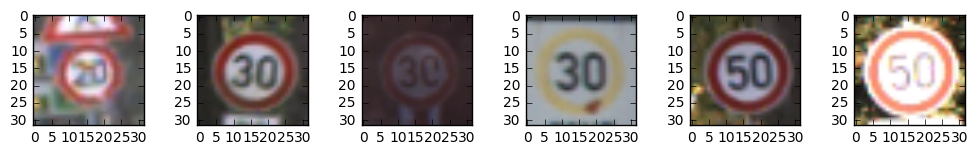

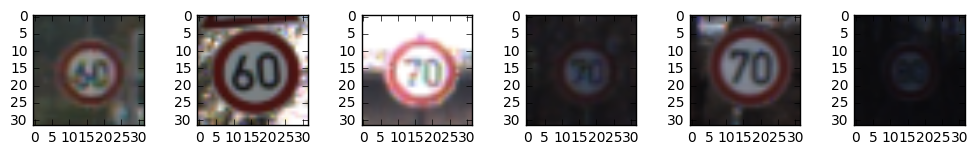

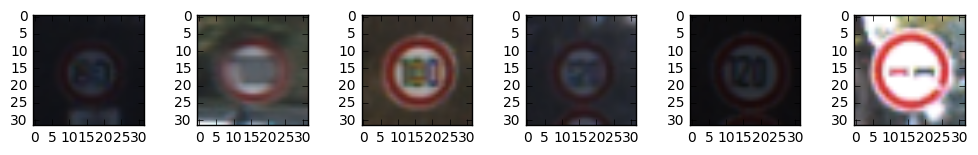

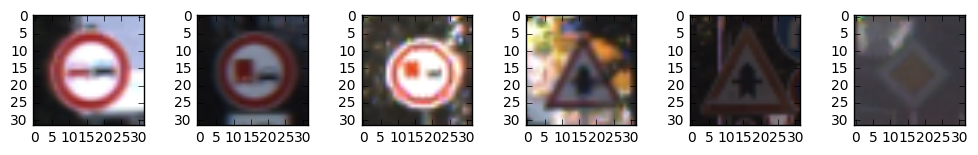

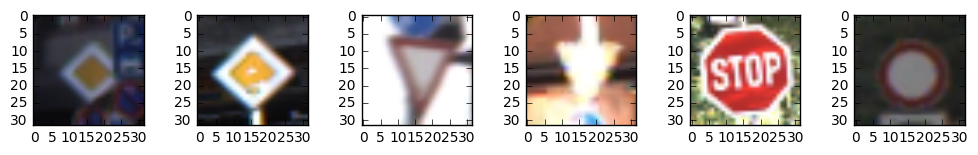

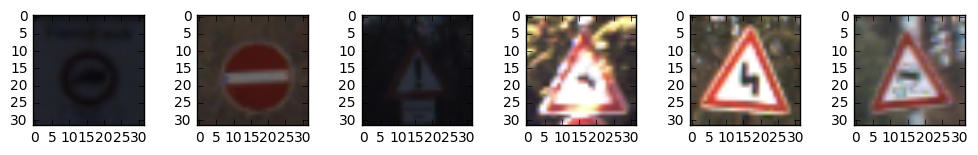

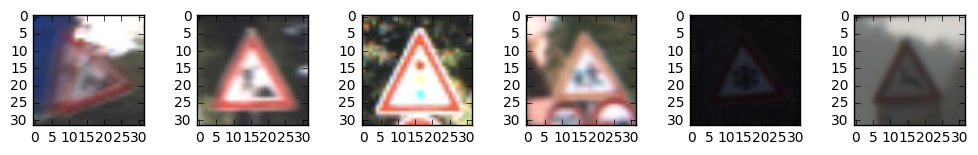

In [21]:
# We randomly display 32 images the dataset
for idx in range(0,32000,4800):
    f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 10))
    f.tight_layout()
    ax1.imshow(train['features'][idx])
    ax2.imshow(train['features'][idx+800])
    ax3.imshow(train['features'][idx+1600])
    ax4.imshow(train['features'][idx+2400])
    ax5.imshow(train['features'][idx+3200])
    ax6.imshow(train['features'][idx+4000])

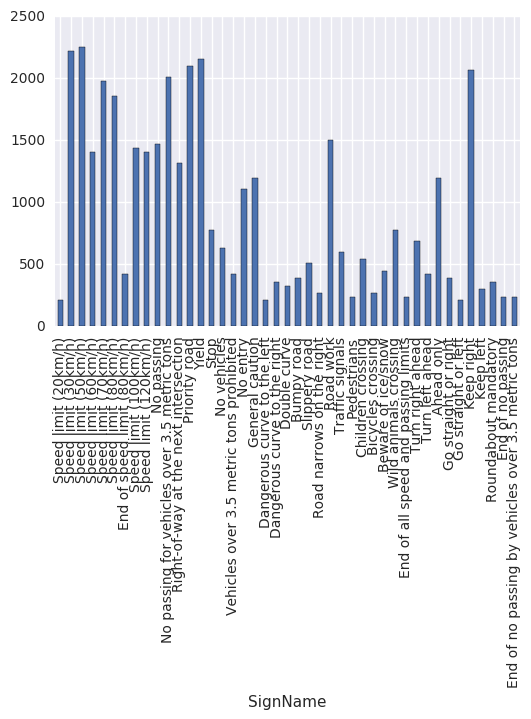

In [15]:
#to see how the classes are distributed in the data 
sign_names = pd.read_csv('signnames.csv')
sign_counts = pd.Series(train['labels']).value_counts().reset_index()\
                    .rename(columns = {'index':'ClassId', 0:'count'})

pd.merge(sign_names, sign_counts).set_index('SignName')['count'].plot(kind = 'bar')

### Data Preprocessing 
* From the figure below we can see that all the values from the same 
class are next to each other as it looks like a cumulative curve. We make a similar graph after shuffling to 
show how shuffling has mixed up the samples

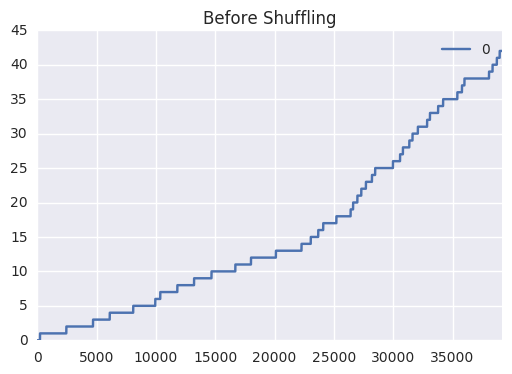

In [11]:
pd.DataFrame(y_train).plot()
plt.title('Before Shuffling')

### When printing the images above one can see that the classes are continous and not shuffled


In [7]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)


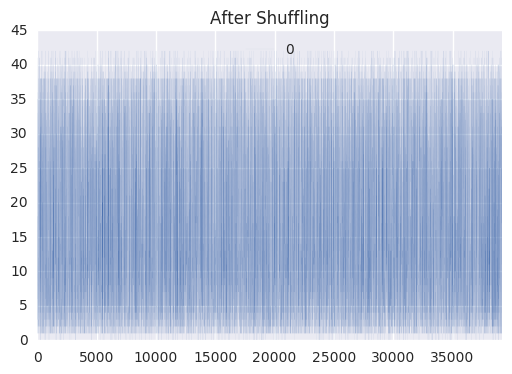

In [13]:
pd.DataFrame(y_train).plot(linewidth = 0.025)
plt.title('After Shuffling')

### Splitting data into train and test sets

In [8]:
#Training and testing data was given to us. 
#For validation i am taking a random sample of 12.5% of the training set
try:
    from sklearn.model_selection import train_test_split
except:
    from sklearn.cross_validation import train_test_split

print ('size before taking out validation', len(X_train))

X_train, X_validation, y_train, y_validation = train_test_split(\
            X_train, y_train, test_size=0.125, random_state=4345)

print ('size after taking out validation', len(X_train))
print (len(X_validation))

size before taking out validation 39209
size after taking out validation 34307
4902


## Design and Test a Model Architecture

### Designing and implementing a deep learning model that learns to recognize traffic signs

* The type of model used is Lenet
The number of layers are 5
The characteristics of the architecture consists of different types of layers and pooling in between. It is as follows:

        Layer 1 (convolution layer) -> Pooling -> layer 2 (convolution layer) 
        -> Pooling -> flattening -> layer 3 (fully connected layer) 
        -> layer 4 (fully connected layer) -> layer 5 (fully connected layer) 
        -> output

* layer 1: input 32x32x3, output 28x28x6
* layer 2: input 14x14x6, output 10x10x16 (pooling reduced size from 28x28x6 to 14x14x6)
* layer 3: input 5x5x16, output 400 (max pooling for 10x10x16 to 5x5x16)  
* layer 4: input 400, output 120
* layer 5: input 120, output 43

In [33]:

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    lay_1w = tf.Variable(tf.truncated_normal(shape = [5, 5, 3, 6], mean = mu, stddev = sigma))
    lay_1b = tf.Variable(tf.zeros(6))
    lay_1 = tf.nn.conv2d(x, lay_1w, strides=[1, 1, 1, 1], padding='VALID')
    lay_1 = tf.nn.bias_add(lay_1, lay_1b)

    # TODO: Activation.
    lay_1 = tf.nn.relu(lay_1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(lay_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    lay_2w = tf.Variable(tf.truncated_normal(shape = [5, 5, 6, 16], mean = mu, stddev = sigma))
    lay_2b = tf.Variable(tf.zeros(16))
    lay_2 = tf.nn.conv2d(pool_1, lay_2w, strides=[1, 1, 1, 1], padding='VALID')
    lay_2 = tf.nn.bias_add(lay_2, lay_2b)
    
    # TODO: Activation.
    lay_2 = tf.nn.relu(lay_2)

    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(lay_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(pool_2)
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc_w = tf.Variable(tf.truncated_normal(shape = (400,120), mean = mu, stddev = sigma))
    fc_b = tf.Variable(tf.zeros(120))
    fc = tf.add(tf.matmul(fc0, fc_w),fc_b)
    # TODO: Activation.
    fc = tf.nn.relu(fc)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc_2w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc_2b = tf.Variable(tf.zeros(84))
    fc2 = tf.add(tf.matmul(fc, fc_2w),fc_2b)
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
        

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc_3w = tf.Variable(tf.truncated_normal(shape = (84,43), mean = mu, stddev = sigma))
    fc_3b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc2, fc_3w),fc_3b)
    
    return logits

In [35]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Model Training

* For each of epoch, the data is shuffled then a batch of the training set is taken for learning. The size of the batch is determined by the BATCH_SIZE. For each batch the values of the Lenet model are updated. This process happens by calculating the cross entropy of output values from the network (model) and one-hot encoded values of the labels (sign labels in this case).
* Taking the mean of the cross entropy gives us the loss function of the model. Using the optimizer, with a specified learning rate, the model parameters values for which the loss function is the lowest are determined.

* Once the model has been trainin for all the batches for a particular epoch, it is tested against a validation set. Since the validation was not used in training this accuracy is more representative of how the model is performing

EPOCHS = 15
BATCH_size = 64
learning rate = 0.0005


In [36]:
#Training Pipeline

rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
#Model Evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = (X_data).shape[0]
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * (batch_x).shape[0])
    return total_accuracy / num_examples

In [14]:
EPOCHS = 15
BATCH_SIZE = 64

logs_path = "/tmp/"

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    num_examples = (X_train).shape[0]
    
    print("Training...")
    print()
    
    #writer = tf.train.SummaryWriter(logs_path, graph=tf.get_default_graph())

    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.729

EPOCH 2 ...
Validation Accuracy = 0.862

EPOCH 3 ...
Validation Accuracy = 0.906

EPOCH 4 ...
Validation Accuracy = 0.922

EPOCH 5 ...
Validation Accuracy = 0.934

EPOCH 6 ...
Validation Accuracy = 0.945

EPOCH 7 ...
Validation Accuracy = 0.948

EPOCH 8 ...
Validation Accuracy = 0.951

EPOCH 9 ...
Validation Accuracy = 0.955

EPOCH 10 ...
Validation Accuracy = 0.960

EPOCH 11 ...
Validation Accuracy = 0.967

EPOCH 12 ...
Validation Accuracy = 0.961

EPOCH 13 ...
Validation Accuracy = 0.962

EPOCH 14 ...
Validation Accuracy = 0.956

EPOCH 15 ...
Validation Accuracy = 0.965

Model saved


### Training Method (trained on AWS)
#### Using the following steps I tuned the parameters 

    EPOCHS = 10
    BATCH_size = 256
    learning rate = 0.001
    Accuracy : 0.957

reducing batch size and reducing learning rate        

    EPOCHS = 10
    BATCH_size = 128
    learning rate = 0.0001
    Accuracy : 0.68
        
Increasing Epochs

    EPOCHS = 25
    BATCH_size = 128
    learning rate = 0.0001
    Accuracy : 0.904
        
Increasing Epochs even more

    EPOCHS = 50
    BATCH_size = 128
    learning rate = 0.0001
    Accuracy : 0.970 
    
A lower learning rate increases accuracy slightly.
Time to change the network

    EPOCHS = 15
    BATCH_size = 128
    learning rate = 0.0005
    change 3rd layer output to 240 and next layer input
    change 4rd layer output to 120 and next layer input
        
    Accuracy : 0.960

Not a significant difference, reverting back to original network
tweaking learning rate and reducing batch size
        
    EPOCHS = 15
    BATCH_size = 64
    learning rate = 0.0005
    change 3rd layer output to 120 and next layer input
    change 4rd layer output to 84 and next layer input
        
    Accuracy : 0.965    
        
settling for the last configuration because it is faster to train and gives one of optimum results

In [15]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.899


##  Test a Model on New Images

Taking several pictures of traffic signs from google images, and running them through the classifier to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

`signnames.csv` contains mappings from the class id (integer) to the actual sign name.

In [39]:
# Links to the images used. Uncomment to download again, otherwise found in the test_images folder
# import urllib
# urllib.request.urlretrieve("https://goo.gl/MtkGcZ", "test_images/1.jpg")
# urllib.request.urlretrieve("https://goo.gl/InRsGj", "test_images/2.jpg")
# urllib.request.urlretrieve("https://goo.gl/slq56i", ""test_images/3.jpg")
# urllib.request.urlretrieve("https://goo.gl/6GvSTG", "test_images/4.jpg")
# urllib.request.urlretrieve("https://goo.gl/i2vap0", "test_images/5.jpg")

('test_images/5.jpg', <http.client.HTTPMessage at 0x7f1961c5f470>)

In [ ]:
#converting the images to 32x32 as our CNN taking those are inputs
import PIL
from PIL import Image

for num in range(1,6):
    img = Image.open(str(num)+'.jpg')
    img = img.resize((32,32), PIL.Image.ANTIALIAS)
    img.save(str(num)+'.jpg') 

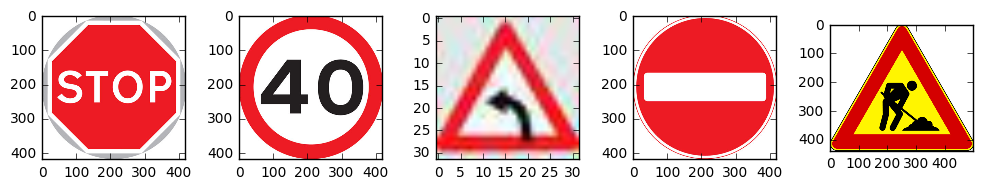

In [40]:
#displaying the images used
from scipy.misc import imread

custom_5_images = []
for images in range(1,6):
    current_image = imread('test_images/'+str(images)+'.jpg')
    custom_5_images.append(current_image)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(10, 10))
f.tight_layout()
ax1.imshow(custom_5_images[0])
ax2.imshow(custom_5_images[1])
ax3.imshow(custom_5_images[2])
ax4.imshow(custom_5_images[3])
ax5.imshow(custom_5_images[4])


* The images are plotted above. These images from randomly selected from google.
* 4 of them are similar to the ones our model has seen but 1 (road work ahead) isn't
* Speed limit 40 is similar but a new image for the classifer. The original set didn't have 40.
* Using this selecting we can find out how the model performs on familiar and new images

### Loading saved model 

In [24]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))
    
    
    custom_preds = sess.run(tf.nn.softmax(logits), feed_dict={x: custom_5_images})

In [25]:
max_value = np.argmax(custom_preds[0]) #stop
print(max_value) #classified as Stop  -> Correct

max_value = np.argmax(custom_preds[1]) #40
print(max_value) #classified as 60km/h  -> Wrong

max_value = np.argmax(custom_preds[2]) #Dangerous Curve to the Left
print(max_value) #classified as Dangerous Curve to the left -> Correct

max_value = np.argmax(custom_preds[3]) #No Entry
print(max_value) #classified as No Entry -> Correct

max_value = np.argmax(custom_preds[4]) #road work ahead
print(max_value) #classified as children crossing   -> Wrong

14
3
19
17
28


* Accuracy is 60% (3/5)
* accuracy of the test set is 89.9%, Model performed better on the test set
* For images in the classifier had seen below it did well. 
* For the ones it had not, it tried to match with closest. For example 40km/h was identified as 60


### Certainty of Predictions

In [27]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    print(sess.run(tf.nn.top_k(custom_preds, 3), feed_dict={x: custom_5_images}))
    

TopKV2(values=array([[  1.00000000e+00,   7.02855870e-30,   3.98819579e-30],
       [  1.00000000e+00,   6.95567701e-11,   4.10022048e-16],
       [  1.00000000e+00,   1.05738176e-26,   2.92224698e-31],
       [  1.00000000e+00,   2.22906232e-25,   8.26381483e-35],
       [  9.99515295e-01,   3.12466058e-04,   1.72147891e-04]], dtype=float32), indices=array([[14,  8,  1],
       [ 3, 35,  5],
       [19, 21, 23],
       [17, 14, 34],
       [28, 23, 20]], dtype=int32))


* For samples that were similar to the ones trained the probability is very high. 
* It can be argued that 40km/h (which is not is the training set ) is similar to other speed limits.
* Road work  has a confidence of 0.99. The second choice for road work choice is also wrong. 